# 1 - Getting Started

_Welcome to GPlately!_

GPlately uses object-oriented programming to make life simple. In this notebook we will explore some of the main objects you will use:

- `PlateReconstruction` - reconstruct features, tessellate mid ocean ridges, subduction zones
- `Points` - partition points onto plates, rotate back through time
- `Raster` - read in NetCDF grids, interpolation, resampling.
- `PlotTopologies` - plotting topologies e.g. ridges, trenches, subduction teeth on maps
- `PlateModelManager` - downloading plate models, features, and rasters e.g. .rot, .gpml, .shp and .nc files

In [2]:
import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
from plate_model_manager import PlateModelManager

## Tectonic plate reconstructions

We simply supply a rotation model, plate topologies, and static polygons to initialise a plate reconstruction model. You can download these files into your machine's cache using GPlately's `PlateModelManager` object.

In [3]:
# Call GPlately's PlateModelManager object and request data from the Müller et al. 2019 study
pm_manager = PlateModelManager()
muller2019_model = pm_manager.get_model("Muller2019", data_dir="plate-model-repo")
rotation_model = muller2019_model.get_rotation_model()
topology_features = muller2019_model.get_topologies()
static_polygons = muller2019_model.get_static_polygons()

# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Now let's find the subduction zones and mid-ocean ridges at 10 Ma.

In [4]:
time = 10

# These bundle a lot of information - check the docs for more info.
subduction_data = model.tessellate_subduction_zones(time)
ridge_data = model.tessellate_mid_ocean_ridges(time)

## Mapping

The `PlotTopologies` function injests the plate model we have defined as well as the coastlines, continents, and COB. It computes all of the plate topologies for a given reconstruction time.

This object has been designed to work specifically with `cartopy`. Define your figure and supply your axes to these plotting routines. Some common favourites include:

- coastlines
- continents
- ridges and transforms
- trenches
- subduction teeth (!!)
- netCDF grids
- plate motion vectors

You can still supply optional keywords as you normally would.

In [16]:
# Obtain features for the PlotTopologies object with PlateModelManager
coastlines = muller2019_model.get_layer('Coastlines')
continents = muller2019_model.get_layer('ContinentalPolygons')
COBs =  muller2019_model.get_layer('COBs')

# Call the PlotTopologies object
gplot = gplately.plot.PlotTopologies(model, coastlines=coastlines, continents=continents, COBs=COBs)

# Download all Muller et al. 2019 netCDF age grids with PlateModelManager. This is returned as a Raster object.
agegrid = gplately.Raster(data=muller2019_model.get_raster("AgeGrids",time))

Set the `time` attribute to reconstruct all topologies to the specified time.

> __IMPORTANT:__ You must set `gplot.time` or provide a `time` at initialisation before plotting anything.

In [17]:
gplot.time = 10 # Ma

Create a map with some useful geological information

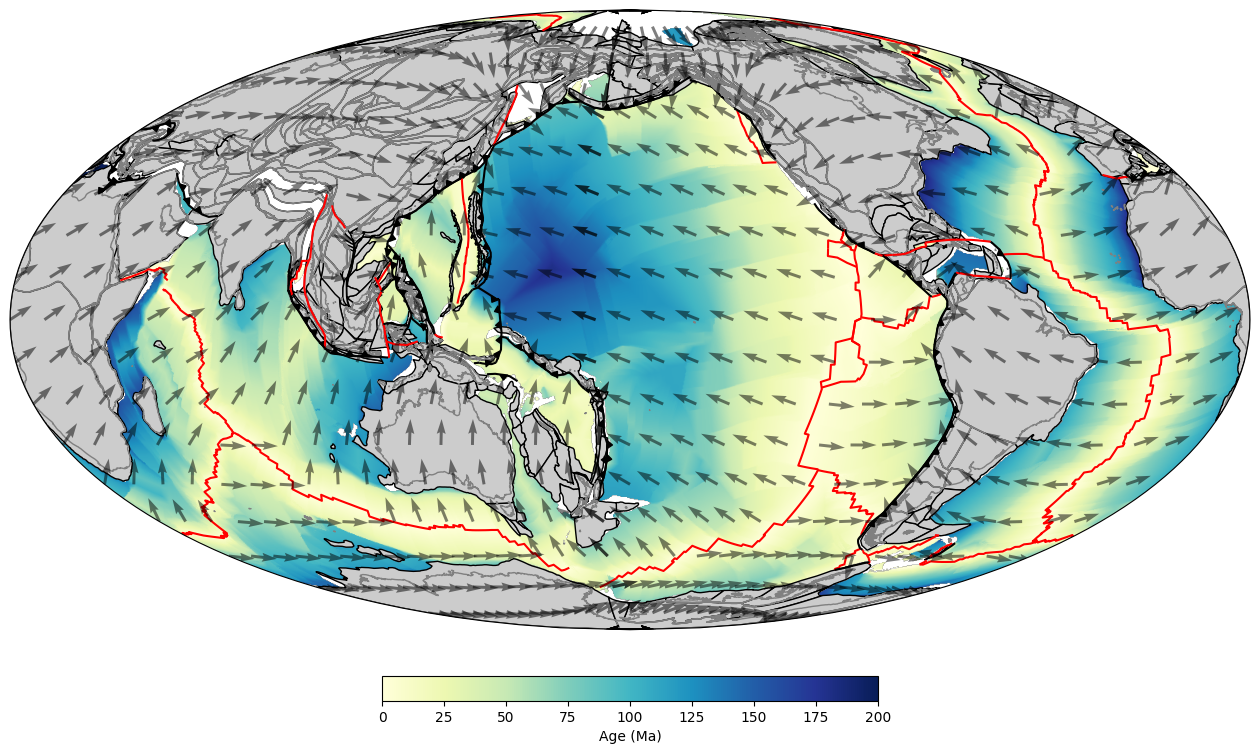

In [18]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges(ax1, color='red')
gplot.plot_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im = gplot.plot_grid(ax1, agegrid.data, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

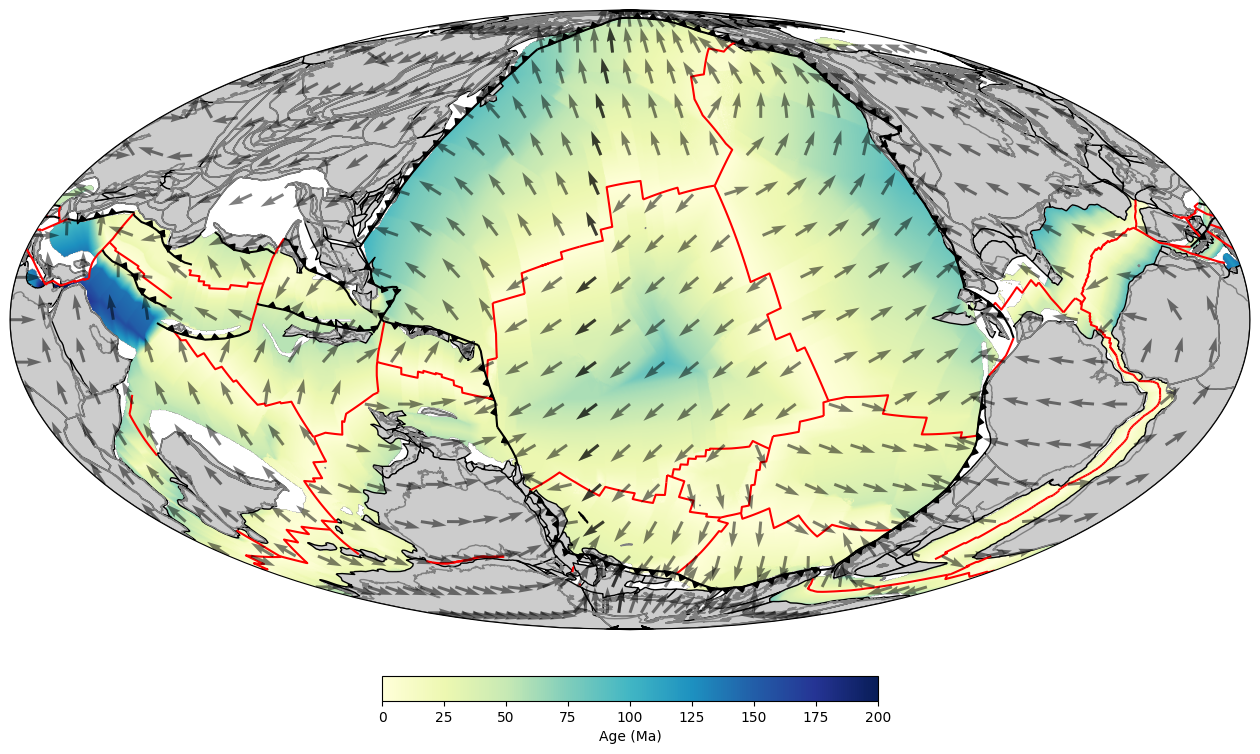

In [19]:
# update the time to regenerate topologies
time = 100
gplot.time = time
agegrid = gplately.Raster(data=muller2019_model.get_raster("AgeGrids",time))

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges(ax1, color='red')
gplot.plot_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im = gplot.plot_grid(ax1, agegrid.data, cmap='YlGnBu', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

## Working with points

Now that we have defined our reconstruction object, we can reconstruct point data.

In [20]:
pt_lons = np.array([140., 150., 160.])
pt_lats = np.array([-30., -40., -50.])

gpts = gplately.Points(model, pt_lons, pt_lats)

# Point velocities at 0 Ma.
vel_x, vel_y = gpts.plate_velocity(0)
vel_mag = np.hypot(vel_x, vel_y)

print("point velocity (cm/yr)", vel_mag)

point velocity (cm/yr) [6.38389518 5.71007208 5.06602802]


Plot their position from `time=0` to `time=20`

In [21]:
rlons = np.empty((21, pt_lons.size))
rlats = np.empty((21, pt_lons.size))


for time in range(0, 21):
    rlons[time], rlats[time] = gpts.reconstruct(time, return_array=True)

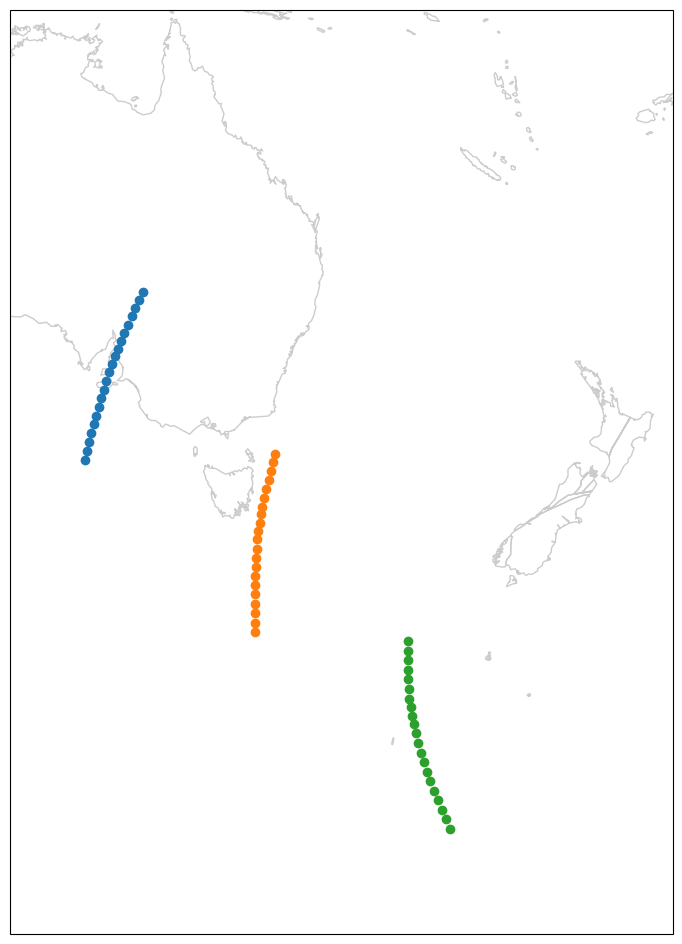

In [22]:
gplot.time = 0 # present day

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mercator(190)) 
ax1.set_extent([130,180,-60,-10])

gplot.plot_coastlines(ax1, color='0.8')

for i in range(0, len(pt_lons)):
    ax1.plot(rlons[:,i], rlats[:,i], 'o', transform=ccrs.PlateCarree())

## Rasters

You can initialise a `Raster` object by providing a raster (either a NetCDF file path or a regular numpy array), and optionally passing a `PlateReconstruction` model. The `data` attribute stores the raster data as a 2D numpy array.

In this example, we will pass a NetCDF file path to the `Raster` object.

In [23]:
time = 100

# download a netcdf age grid Raster and assign a plate reconstruction `model'
graster = gplately.Raster(data=muller2019_model.get_raster("AgeGrids",time))
graster.plate_reconstruction = model

# the underlying numpy (masked) array can be accessed using the data attribute
print(type(graster.data))

# alternatively initialise a Raster from a numpy array
graster = gplately.Raster(data=graster.data, # 2D numpy array
                          plate_reconstruction=model, # PlateReconstruction object
                          extent='global', # equivalent to [-180, 180, -90, 90]
                          time=100, # time in Ma
                         )


<class 'numpy.ma.core.MaskedArray'>


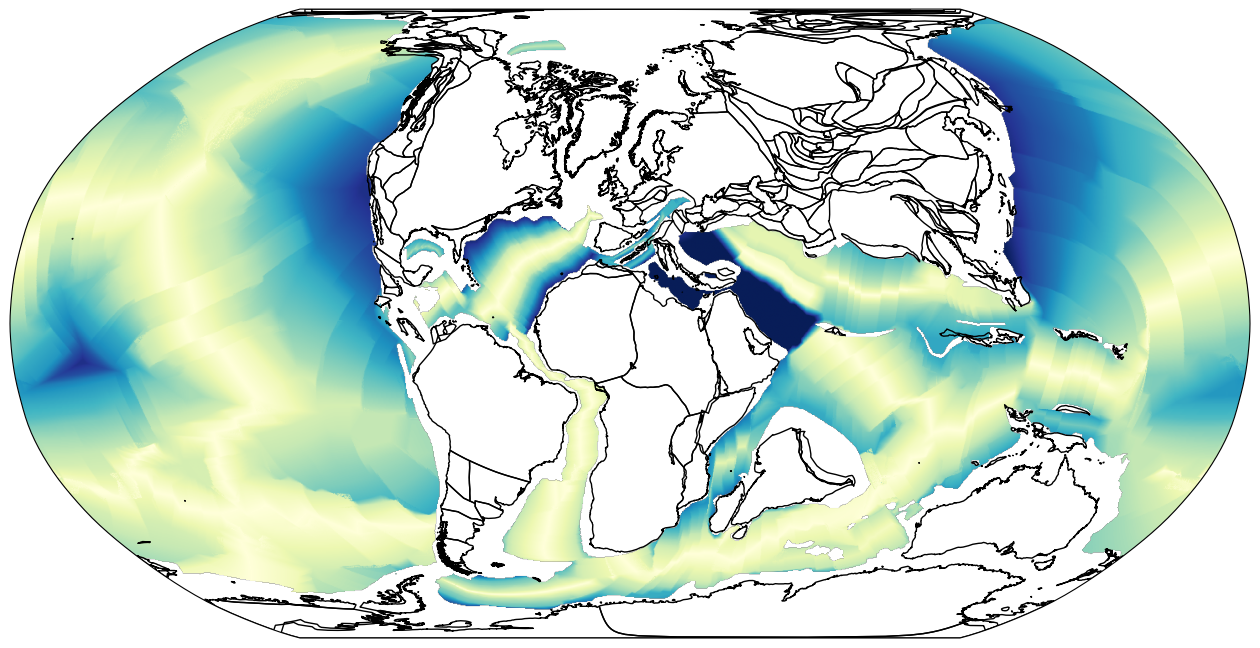

In [24]:
gplot.time = time

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Robinson())
gplot.plot_grid(ax1, graster, cmap='YlGnBu', vmin=0, vmax=100)
# Alternatively:
# graster.imshow(ax=ax1, cmap="YlGnBu", vmin=0, vmax=100)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='none')

There are a bunch of routines such as,

- filling masked (NaN) regions
- interpolation
- resampling
- reconstructing rasters

In-place operations can be achieved using `inplace=True` which will update the internal data structures.